## Get data

In [2]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime, timezone
from vnstock3 import Vnstock
import requests

In [3]:
stock_list = []
volume_list = []

for i in glob.glob(r'D:\Quantitative_Research\H-Tech\vnstock_data\*.csv'):
    stocks = pd.read_csv(i).set_index('time')['close'].reset_index()
    volume = pd.read_csv(i).set_index('time')['volume'].reset_index()
    stocks.columns = ['time', i[-7:-3]]
    volume.columns = ['time', i[-7:-3]]
    stock_list.append(stocks.set_index('time'))
    volume_list.append(volume.set_index('time'))

stock_universe_price = pd.concat(stock_list, axis = 1).sort_index()
stock_universe_vol = pd.concat(volume_list, axis = 1).sort_index()

## Data handling

In [4]:
stock_universe_price.rename(columns=lambda x: x[:-1] if x != 'time' else x, inplace=True)
stock_universe_price.index = pd.to_datetime(stock_universe_price.index)
stock_universe_vol.rename(columns=lambda x: x[:-1] if x != 'time' else x, inplace=True)
stock_universe_vol.index = pd.to_datetime(stock_universe_vol.index)

## Get industry

In [5]:
stock = Vnstock().stock()
industries = stock.listing.symbols_by_industries()
industry_counts = industries['en_icb_name3'].value_counts()
valid_industries = industry_counts[industry_counts >= 3].index.tolist()

print(f"Valid industries: {valid_industries}")

valid_industries = list(set(valid_industries))

2024-08-07 08:56:47,931 - vnstock3.common.vnstock - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
2024-08-07 08:56:47,950 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


Valid industries: ['Construction & Materials', 'Real Estate Investment & Services', 'Industrial Transportation', 'Food Producers', 'Gas, Water & Multi-utilities', 'Chemicals', 'Personal Goods', 'Support Services', 'Electricity', 'Travel & Leisure', 'Pharmaceuticals & Biotechnology', 'Industrial Metals & Mining', 'Mining', 'Beverages', 'Financial Services', 'Industrial Engineering', 'Media', 'General Industrials', 'Banks', 'General Retailers', 'Electronic & Electrical Equipment', 'Forestry & Paper', 'Automobiles & Parts', 'Technology Hardware & Equipment', 'Software & Computer Services', 'Nonlife Insurance', 'Health Care Equipment & Services', 'Household Goods & Home Construction', 'Oil Equipment, Services & Distribution', 'Fixed Line Telecommunications', 'Food & Drug Retailers', 'Tobacco', 'Oil & Gas Producers', 'Mobile Telecommunications', 'Leisure Goods']


## Specify universe by Industry

In [285]:
ticker_list = industries[industries['en_icb_name3'] == 'Industrial Transportation']['symbol'].tolist()
available_tickers = [ticker for ticker in ticker_list if ticker in stock_universe_price.columns]
stock_universe = stock_universe_price[available_tickers]
stock_universe = stock_universe.ffill().fillna(0)
stock_universe.index = pd.to_datetime(stock_universe.index)
stock_universe.index = stock_universe.index.date
stock_universe.index.name = 'date'
stock_universe

,CLL,CIA,SGP,IST,CCT,CPI,DNL,CAG,DOP,CDN,...,VFC,VMT,VGP,VIP,VIN,VNA,VST,VTP,WTC,WCS
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.84,0.0,6.90,2.10,0.0,1.65,2.5,0.0,4.15,19.91
2013-01-03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.45,0.0,6.73,2.10,0.0,1.65,2.4,0.0,4.15,18.84
2013-01-04,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.45,0.0,6.79,2.07,0.0,1.59,2.5,0.0,4.15,18.84
2013-01-07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.74,0.0,7.01,2.07,0.0,1.53,2.5,0.0,4.15,18.84
2013-01-08,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.45,0.0,6.56,2.07,0.0,1.59,2.5,0.0,4.15,17.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18,41.35,11.0,26.5,37.5,9.6,3.8,32.0,8.3,12.0,31.8,...,79.00,22.9,29.40,14.45,18.8,18.10,3.3,81.0,12.60,227.00
2024-07-19,41.60,11.0,25.5,37.5,9.7,3.8,28.0,8.2,12.0,30.7,...,79.00,22.9,29.00,14.35,18.8,17.50,2.9,79.0,12.60,230.00
2024-07-22,41.40,11.0,24.3,36.9,9.6,3.8,28.0,8.3,12.0,31.0,...,79.00,19.5,28.90,13.45,18.8,17.00,2.9,78.5,12.60,230.00


In [286]:
ticker_list = industries[industries['en_icb_name3'] == 'Industrial Transportation']['symbol'].tolist()
available_tickers = [ticker for ticker in ticker_list if ticker in stock_universe_vol.columns]
vol = stock_universe_vol[available_tickers]
vol = vol.fillna(0)
vol.index = pd.to_datetime(vol.index)
vol.index = vol.index.date
vol.index.name = 'date'

## Most liquid tickers

In [287]:
average_volume = vol.mean()
sorted_tickers = average_volume.sort_values(ascending=False)
top_3_tickers = sorted_tickers.head(3).index.tolist()
top_3_tickers = [ticker for ticker in top_3_tickers if ticker != 'FLC']
stock_universe = stock_universe[top_3_tickers]
stock_universe

,PVT,GMD,VOS
date,,,
2013-01-02,2.05,6.61,2.40
2013-01-03,2.15,6.61,2.50
2013-01-04,2.19,6.92,2.50
2013-01-07,2.15,6.92,2.50
2013-01-08,2.15,7.24,2.50
...,...,...,...
2024-07-18,29.35,79.90,18.95
2024-07-19,28.50,78.80,17.80
2024-07-22,27.40,78.00,16.65


## Train-test split

In [288]:
stock_universe_train = stock_universe.iloc[:-504]
stock_universe_test = stock_universe.iloc[-504:]

## Contrarian momentum strategy

In [289]:
def alpha_signal(df, delta_window=5):
    alpha_df = pd.DataFrame(index=df.index, columns=df.columns)
    
    for col in df.columns:
        delta_close = df[col].diff()
        ts_min = delta_close.rolling(window=delta_window).min()
        ts_max = delta_close.rolling(window=delta_window).max()
        
        alpha_df[col] = np.where(
            ts_min > 0, 
            delta_close, 
            np.where(ts_max < 0, delta_close, -delta_close)
        )
    
    return alpha_df

## Order matrix (adjust T + 3)

In [290]:
def orders(df, delta_window=5, threshold = 0):
    ords = pd.DataFrame(0, index=df.index, columns=df.columns)
    alpha_df = alpha_signal(df, delta_window=delta_window)
    for col in df.columns:
        last_order = 0
        holding_period = 0
        days_since_last_sell = 0
        for i in range(1, len(df)):
            if df[col].iloc[i - 1] > 0 and df[col].iloc[i] > 0:
                bull = alpha_df[col].iloc[i - 1] > threshold
                bear = alpha_df[col].iloc[i - 1] < threshold
                
                # print(f"Index {i}, Col {col}, Bull {bull}, Bear {bear}, Last Order {last_order}, Holding Period {holding_period}, Days Since Last Sell {days_since_last_sell}")
                
                if bull:
                    if last_order == -1 and days_since_last_sell < 3:
                        ords[col].iloc[i] = 0
                        days_since_last_sell += 1
                    elif last_order == 1:
                        ords[col].iloc[i] = 0
                        holding_period += 1
                    elif last_order == 0:
                        ords[col].iloc[i] = 1
                        last_order = 1
                        days_since_last_sell = 0
                        holding_period += 1
                    elif last_order == -1 and days_since_last_sell >= 3:
                        ords[col].iloc[i] = 1
                        last_order = 1
                        days_since_last_sell = 0
                        holding_period += 1
                    else:
                        ords[col].iloc[i] = 1
                        last_order = 1
                        days_since_last_sell = 0
                        holding_period += 1
                elif bear and holding_period >= 3:
                    ords[col].iloc[i] = -1
                    last_order = -1
                    holding_period = 0
                    days_since_last_sell += 1
                elif last_order == 1 and not bull:
                    ords[col].iloc[i] = 0
                    last_order = 1
                    holding_period += 1
                elif last_order == -1 and not bear:
                    ords[col].iloc[i] = 0
                    last_order = -1
                    days_since_last_sell += 1

    return ords

In [291]:
def calculate_pnl(order_matrix, stock_universe, capital=1000000000):
    num_stocks = len(order_matrix.columns)
    capital_per_stock = capital / num_stocks
    pnl_matrix = pd.DataFrame(np.zeros_like(order_matrix.values), index=order_matrix.index, columns=order_matrix.columns)
    
    for stock in order_matrix.columns:
        buy_prices = []
        holding_days = []

        for i in range(len(order_matrix)):
            order_signal = order_matrix.iloc[i, order_matrix.columns.get_loc(stock)]
            price = stock_universe.iloc[i, stock_universe.columns.get_loc(stock)]
            
            if order_signal == 1:
                # Buy with capital allocation
                buy_price = price
                shares_to_buy = capital_per_stock / buy_price
                buy_prices.append(buy_price)
                holding_days.append(1)
                      
            elif order_signal == -1:
                sell_indices = [idx for idx, days in enumerate(holding_days) if days >= 3]
                if sell_indices:
                    pnl = round(sum((price - buy_prices[idx]) * (capital_per_stock / buy_prices[idx]) for idx in sell_indices), 2)
                    pnl_matrix.iloc[i, pnl_matrix.columns.get_loc(stock)] += pnl
                    buy_prices = [buy_prices[idx] for idx in range(len(buy_prices)) if idx not in sell_indices]
                    holding_days = [days for idx, days in enumerate(holding_days) if idx not in sell_indices]
            else:
                if len(holding_days) >= 1:
                    holding_days = [x + 1 for x in holding_days]
                    
    return pnl_matrix


In [292]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = running_max - cum_ret
    max_dd = (drawdown.max() / cum_ret.max()) * 100
    return sharpe, max_dd

## IS backtest

Sharpe ratio: 1.13
Max drawdown: 14.50%


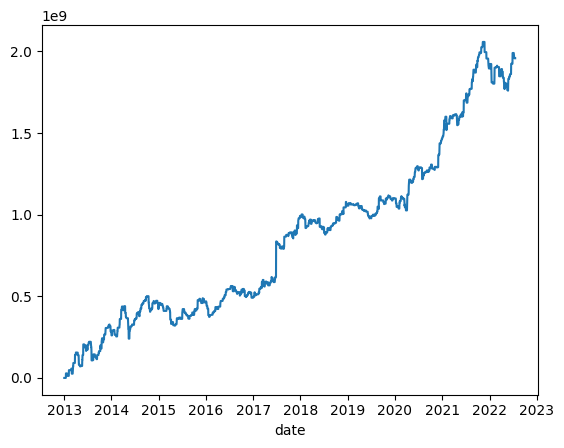

In [296]:
order_matrix = orders(stock_universe_train)
pnl_matrix = calculate_pnl(order_matrix, stock_universe_train)
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl) 
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2f}%")

## OS backtest

Sharpe ratio: 1.25
Max drawdown: 26.51%


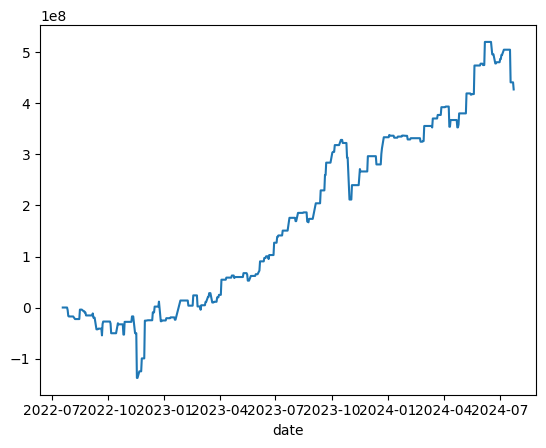

In [297]:
order_matrix = orders(stock_universe_test)
pnl_matrix = calculate_pnl(order_matrix, stock_universe_test)
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl) 
print(f"Sharpe ratio: {sharpe:.2f}") 
print(f"Max drawdown: {max_dd:.2f}%")